<!-- # Notebook for Scor-O - Viz
- reads in the table of season's scores and outputs a vizualization of the density of result combinations -->

# Scoragmi Visualization Book
- Creates heatmap visualization of all combinations of scores in D1 men's and women's hockey for the season

- Men's schedule download not working currently - outputs empty - locally stored tables work fine, woman's results downloader workes fine



In [115]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from dateutil.relativedelta import relativedelta
import datetime
from bs4 import BeautifulSoup
import requests
import re


# store current date as sring (format 9/28/83)
today = datetime.datetime.now().strftime('%m/%d/%y')
# string with no slashes
today_ns = today.replace('/', '')

figure_ratio = (10, 10)

# Define paths
scor_o_path = os.path.join('..', 'TEMP', 'IMAGES')


####################
# TO USE LOCAL RESULTS TABLE ##

# Load Results Table - in the format of CHN Schedule Tables
# filename = 'Week 1 Scores'
# data_path = os.path.join('..', 'data', 'schedule', f'{filename}.csv')
# data = pd.read_csv(data_path) # Load to dataframe

# # data.head() # Check Dataframe


############ USE WEB SCRAPING TO GET RESULTS TABLE ############
current_year_url = 'https://www.collegehockeynews.com/schedules/?season=20242025'

In [116]:
### SET COLOR PALLETTE FOR PLOTS

# set_pallette = "viridis"
set_pallette = "plasma"
# set_pallette = "inferno"
# set_pallette = "magma"
# set_pallette = "cividis"
# set_pallette = "coolwarm"
# set_pallette = "Pastel1"
# set_pallette = "Set2"
# set_pallette = "tab10"



### Download Current Results Table from College Hockey News
- Something not working, appears to download the schedule correctly but something goes wrong when sending to data transformation
- code taken from roster_scrape_and_clean notebook

<!-- ## Data Transform -->

In [117]:
## Functions
### Parse the current season schedule / results page
############ USE WEB SCRAPING TO GET RESULTS TABLE ############
current_year_url = 'https://www.collegehockeynews.com/schedules/?season=20242025'

def parse_current_season(url):
        # Initialize variables
    current_date = None
    current_conference = None
    game_notes = None

    # Initialize an empty list to hold the data
    data = []

    # Parse the page with BeautifulSoup
    # Get the page with requests
    response = requests.get(url)

    # Create a BeautifulSoup object
    soup = BeautifulSoup(response.text, 'html.parser')

    # select the table or tables
    tables = soup.find_all('table')

    rows = soup.find_all('tr')

    # Loop through each row to find relevant information
    for row in rows:
        # Check for date row
        if row.get('class') == ['stats-section']:
            current_date = row.find('td').text.strip()
        # Check for conference row
        elif row.get('class') == ['sked-header']:
            current_conference = row.find('td').text.strip()
        # Check for game notes
        elif len(row.find_all('td')) == 2:
            game_notes = row.find_all('td')[1].text.strip()
        # Process rows with game data
        elif row.get('valign') == 'top':
            cells = row.find_all('td')
            if len(cells) >= 9:
                home_team = cells[0].text.strip()
                # Remove any hyphens from the team name
                home_team = home_team.replace('-', ' ')
                home_team_link = cells[0].find('a')['href'] if cells[0].find('a') else None
                home_score = cells[1].text.strip()
                away_team = cells[3].text.strip()
                away_team_link = cells[3].find('a')['href'] if cells[3].find('a') else None
                away_score = cells[4].text.strip()
                ot = cells[5].text.strip()
                box_link = cells[7].find('a')['href'] if cells[7].find('a') else None
                metrics_link = cells[8].find('a')['href'] if cells[8].find('a') else None
                # Capture Game Notes
                game_notes_cell = cells[-1].find('small')
                game_notes = game_notes_cell.text.strip() if game_notes_cell else None

                # Append data to the list
                data.append([current_date, current_conference, game_notes, home_team, home_team_link, home_score, away_team, away_team_link, away_score, ot, box_link, metrics_link])
                game_notes = None  # Reset game notes for the next row
    return data

## call the function
data = parse_current_season(current_year_url)


# Create a dataframe from the list

columns = ['Date', 'Conference', 'Game_Notes', 'Away_Team', 'Away_Team_Link', 'Away_Score', 'Home_Team', 'Home_Team_Link', 'Home_Score', 'OT', 'Box_Link', 'Metrics_Link']
df = pd.DataFrame(data, columns=columns)
            
## Extract the day of the week from the date and save in new column
df['Day'] = pd.to_datetime(df['Date']).dt.day_name()
# remove day of the week from date
# format data column as YYYY-MM-DD
df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d')

### Create a new column for the game ID
## Game ID will be a combination of the date and abbreviated team names

# Loop to abbreviate the team names
for row in df.itertuples():
    home_team = row.Home_Team
    away_team = row.Away_Team
    home_team_abbr = home_team.split(' ')[-1]
    away_team_abbr = away_team.split(' ')[-1]
    # Remove any hyphens from the team name if there are any
    home_team_abbr = home_team_abbr.replace('-', ' ')
    away_team_abbr = away_team_abbr.replace('-', ' ')
    game_id = f'{row.Date}-{home_team_abbr}-{away_team_abbr}'
    df.loc[row.Index, 'Game_ID'] = game_id

# Create a new column for the game ID
df['Game_ID'] = df['Game_ID'].str.replace(',', '')

# Remove any hyphens from the team names if any
df['Home_Team'] = df['Home_Team'].str.replace('-', ' ')
df['Away_Team'] = df['Away_Team'].str.replace('-', ' ')

# Apply the function to the DataFrame
df['Game_ID'] = df.apply(lambda row: f'{row.Date}-{row.Home_Team}-{row.Away_Team}', axis=1)

## Filter out games that have not been played yet
df = df[df['Home_Score'] != '']

# Replace Nan values in metrics column with empty string
df['Metrics_Link'] = df['Metrics_Link'].fillna('')

In [118]:
# Print length of dataframe before and after filtering for exhibition games
print(f'Length of dataframe before filtering for exhibition games: {len(df)}')

# Filter out exhibition games - Conference = Exhibition
df = df[df['Conference'] != 'Exhibition']

print(f'Length of dataframe after filtering for exhibition games: {len(df)}')


Length of dataframe before filtering for exhibition games: 208
Length of dataframe after filtering for exhibition games: 174


In [119]:
print(len(df))

# Store the dataframe as games_df
data = df.copy()

# df.tail(10)

# save the dataframe to a csv file for manual review
# df.to_csv('../TEMP/season_table_test.csv')



174


In [120]:
# data.info()
# data.head()

#### OLD CODE - MAY DELETE

In [121]:
# # Set the URL to scrape
# url_base = 'https://www.collegehockeynews.com/schedules/?season=' # Link to the 2022-2023 season with all results

# url_season = '20242025' #### Set the season varriable portion of the url 
# file_tag = f'd1_mens_results_thru{today}'#### string to add to file names and whatnot

# # Set output directory
# output_dir = os.path.join('..', 'TEMP')

# ## Construct the url to feed to parser
# url = url_base + url_season

# # Get the page with requests
# response = requests.get(url)

# # Create a BeautifulSoup object
# soup = BeautifulSoup(response.text, 'html.parser')

# # select the table or tables
# tables = soup.find_all('table')

# # Initialize variables
# current_date = None
# current_conference = None
# game_notes = None

# # Initialize an empty list to hold the data
# data = []

# # Parse the table with BeautifulSoup

# rows = soup.find_all('tr')

# # Loop through each row to find relevant information
# for row in rows:
#     # Check for date row
#     if row.get('class') == ['stats-section']:
#         current_date = row.find('td').text.strip()
#     # Check for conference row
#     elif row.get('class') == ['sked-header']:
#         current_conference = row.find('td').text.strip()
#     # Check for game notes
#     elif len(row.find_all('td')) == 2:
#         game_notes = row.find_all('td')[1].text.strip()
#     # Process rows with game data
#     elif row.get('valign') == 'top':
#         cells = row.find_all('td')
#         if len(cells) >= 9:
#             home_team = cells[0].text.strip()
#             home_team_link = cells[0].find('a')['href'] if cells[0].find('a') else None
#             home_score = cells[1].text.strip()
#             away_team = cells[3].text.strip()
#             away_team_link = cells[3].find('a')['href'] if cells[3].find('a') else None
#             away_score = cells[4].text.strip()
#             ot = cells[5].text.strip()
#             box_link = cells[7].find('a')['href'] if cells[7].find('a') else None
#             metrics_link = cells[8].find('a')['href'] if cells[8].find('a') else None
#              # Capture Game Notes
#             game_notes_cell = cells[-1].find('small')
#             game_notes = game_notes_cell.text.strip() if game_notes_cell else None

#             # Append data to the list
#             data.append([current_date, current_conference, game_notes, home_team, home_team_link, home_score, away_team, away_team_link, away_score, ot, box_link, metrics_link])
#             game_notes = None  # Reset game notes for the next row
            

# # Create a DataFrame
# columns = ['Date', 'Conference', 'Game_Notes', 'Away_Team', 'Away_Team_Link', 'Away_Score', 'Home_Team', 'Home_Team_Link', 'Home_Score',  'OT', 'Box_Link', 'Metrics_Link']
# df = pd.DataFrame(data, columns=columns)

# ## Extract the day of the week from the date and save in new column
# df['Day'] = pd.to_datetime(df['Date']).dt.day_name()
# # remove day of the week from date
# # format data column as YYYY-MM-DD
# df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d')

# ### Create a new column for the game ID
# ## Game ID will be a combination of the date and abbreviated team names

# # Function to abbreviate the team names
# for row in df.itertuples():
#     home_team = row.Home_Team
#     away_team = row.Away_Team
#     home_team_abbr = home_team.split(' ')[-1]
#     away_team_abbr = away_team.split(' ')[-1]
#     game_id = f'{row.Date}_{home_team_abbr}_{away_team_abbr}'
#     df.loc[row.Index, 'Game_ID'] = game_id

# # Create a new column for the game ID
# df['Game_ID'] = df['Game_ID'].str.replace(',', '')

# # Apply the function to the DataFrame
# df['Game_ID'] = df.apply(lambda row: f'{row.Date}_{row.Home_Team}_{row.Away_Team}', axis=1)

# ## Remove periods from team names
# df['Home_Team'] = df['Home_Team'].str.replace('.', '')
# df['Away_Team'] = df['Away_Team'].str.replace('.', '')
# # Replace Dashes with spaces
# df['Home_Team'] = df['Home_Team'].str.replace('-', ' ')
# df['Away_Team'] = df['Away_Team'].str.replace('-', ' ')
# # Replace ' with space
# df['Home_Team'] = df['Home_Team'].str.replace("'", '')
# df['Away_Team'] = df['Away_Team'].str.replace("'", '')


# # Strip whitespace
# df['Home_Team'] = df['Home_Team'].str.strip()
# df['Away_Team'] = df['Away_Team'].str.strip()

# data = df.copy() # Save a copy of the data
# data.head() # Check Dataframe


In [122]:

# # Filter out exhibition games
# # filtered_data = data[data['Conference'] != 'Exhibition']
# # filtered_data = data[data['Conference'] != 'Exhibition']

# # Determine the maximum scores for both home and away teams to set up the axes
# # and make sure they are integers
# max_home_score = filtered_data['Home_Score'].max()
# max_away_score = filtered_data['Away_Score'].max()
# max_home_score, max_away_score = int(max_home_score), int(max_away_score)

# # Calculate the total home wins (Home_Score > Away_Score)
# home_wins = len(filtered_data[filtered_data['Home_Score'] > filtered_data['Away_Score']])

# # Calculate the total away wins (Away_Score > Home_Score)
# away_wins = len(filtered_data[filtered_data['Away_Score'] > filtered_data['Home_Score']])

# # Calculate ties, if any (optional)
# ties = len(filtered_data[filtered_data['Home_Score'] == filtered_data['Away_Score']])



# # Create a pivot table to aggregate game counts for each score combination
# score_combinations = pd.pivot_table(filtered_data, index='Home_Score', columns='Away_Score', values='Date', aggfunc='count', fill_value=0)

# # Fill in any missing score combinations with zeros (in case some scores don't appear in the dataset)
# all_scores = np.arange(0, max(max_home_score, max_away_score) + 1)  # +1 to include the max score itself
# score_combinations = score_combinations.reindex(index=all_scores, columns=all_scores, fill_value=0)
# # Make sure the numbers in the headers pivot table are integers
# score_combinations = score_combinations.astype(int)
# score_combinations

# # data.head()

<!-- ## Basic Plotting Code
- taken from 2023-24 project workbook -->

In [123]:
# # look for Exhibition games and filter them out
# # Value COunt of conference
# # print(data['Conference'].value_counts())
# print(len(data)) # Check length of data

# # Filter out exhibition games
# filtered_data = data[data['Conference'] != 'Exhibition']

# # check the value counts of the conference column
# print(filtered_data['Conference'].value_counts())
# print(len(filtered_data)) # Check length of filtered_data

# # # Value COunts of Scores
# # filtered_data['Home_Score'].value_counts()
# # filtered_data['Away_Score'].value_counts()

## Mens D1 Plot - Working Copy

#### Hotfix because home and away are being assigned incorreectly

In [124]:
######### HOTFIX - Home and away are switched in the data ########
####### Switch Home and Away Scores, teams, and links, ect. ########

# # Switch Home and Away Scores
# data['Home_Score'], data['Away_Score'] = data['Away_Score'], data['Home_Score']
# data['Home_Team'], data['Away_Team'] = data['Away_Team'], data['Home_Team']
# data['Home_Team_Link'], data['Away_Team_Link'] = data['Away_Team_Link'], data['Home_Team_Link']


## SHOULD BE UNNECESSARY NOW THAT THE DATA IS CLEANED UP

# data.head()

##### Hide Code

In [125]:



## NOT NESS FOR WOMAN'S TABLE FOR SOME REASON - BREAKS WHEN UNCOMMENTED
# Filter out exhibition games 
# filtered_data = data[data['Conference'] != 'Exhibition']
filtered_data = data.copy()

# make sure Home_Score and Away_Score are integers
filtered_data['Home_Score'] = filtered_data['Home_Score'].astype(int)
filtered_data['Away_Score'] = filtered_data['Away_Score'].astype(int)

# Determine the maximum scores for both home and away teams to set up the axes
# and make sure they are integers
max_home_score = filtered_data['Home_Score'].max()
max_away_score = filtered_data['Away_Score'].max()
max_home_score, max_away_score = int(max_home_score), int(max_away_score)

# Calculate the total home wins (Home_Score > Away_Score)
home_wins = len(filtered_data[filtered_data['Home_Score'] > filtered_data['Away_Score']])

# Calculate the total away wins (Away_Score > Home_Score)
away_wins = len(filtered_data[filtered_data['Away_Score'] > filtered_data['Home_Score']])

# Calculate ties, if any (optional)
ties = len(filtered_data[filtered_data['Home_Score'] == filtered_data['Away_Score']])



# Create a pivot table to aggregate game counts for each score combination
score_combinations = pd.pivot_table(filtered_data, index='Home_Score', columns='Away_Score', values='Date', aggfunc='count', fill_value=0)

# Fill in any missing score combinations with zeros (in case some scores don't appear in the dataset)
all_scores = np.arange(0, max(max_home_score, max_away_score) + 1)  # +1 to include the max score itself
score_combinations = score_combinations.reindex(index=all_scores, columns=all_scores, fill_value=0)
# Make sure the numbers in the headers pivot table are integers
score_combinations = score_combinations.astype(int)
score_combinations

# data.head()


Away_Score,0,1,2,3,4,5,6,7,8
Home_Score,,,,,,,,,
0,1,5,3,3,2,1,0,0,0
1,1,1,10,2,7,5,1,1,1
2,0,13,1,8,5,3,2,0,0
3,3,5,8,6,5,1,4,1,1
4,1,12,8,10,3,4,0,0,0
5,1,2,7,1,0,1,0,1,0
6,1,2,3,1,0,2,0,0,0
7,0,1,1,0,0,0,0,0,0
8,1,0,1,0,0,0,0,0,0


In [126]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap

date = today
# Define figure size to maintain a 4:5 ratio while ensuring the heatmap grid stays 1:1
figure_ratio = (8, 10)  # Adjusted for mobile-friendly aspect ratio
# Create Function to plot the scorigami
def plot_scorigami(score_combinations, home_wins, away_wins, ties, date):

    # Customizing the colormap with transparency for zeros
    cmap = sns.color_palette(palette=set_pallette, as_cmap=True)
    cmap_with_transparency = ListedColormap([(0,0,0,0)] + [cmap(i) for i in range(1, cmap.N)])

    # Create a figure with constrained layout to ensure the grid aspect stays 1:1
    fig = plt.figure(figsize=figure_ratio)

    # Create the title
    plt.suptitle("2024-25 Men's D1 Hockey Scorigami", fontsize=24, fontweight='bold', color='black', y=0.98)
    # Create Subtitle for the week #
    plt.title(f'Week 1', fontsize=18, fontweight='bold', color='black', y=0.95)

    # Create a new axis for the heatmap with the grid maintaining a 1:1 aspect ratio
    # ax1 = fig.add_axes([0.05, 0.2, 0.98, 0.6])  # Adjusted placement to reduce whitespace
    # Placement for mobile-friendly aspect ratio
    ax1 = fig.add_axes([0.05, 0.05, 0.975, 0.995])  # Adjusted placement to reduce whitespace
    sns.heatmap(score_combinations, annot=True, mask=None, cmap=cmap_with_transparency, fmt="d", linewidths=.25, 
                linecolor='gray', cbar=False, square=True, ax=ax1)

    # Invert y-axis to ensure 0 is at the bottom
    ax1.invert_yaxis()

    # Axis labels
    ax1.set_xlabel('Away', fontsize=12) #, labelpad=10)
    # Rotate the y-axis label 90 degrees for better readability
    ax1.set_ylabel('Home', fontsize=12, rotation=90, labelpad=10)



    # ax1.set_ylabel('Home', fontsize=12) # labelpad=10)

    # Customize tick labels
    ax1.set_xticks(np.arange(0.5, len(all_scores)+0.5, 1))
    ax1.set_xticklabels(all_scores, fontsize=14)
    ax1.set_yticks(np.arange(0.5, len(all_scores)+0.5, 1))
    ax1.set_yticklabels(all_scores, fontsize=14)

    # Add a diagonal line for home vs away parity
    ax1.plot([0, len(all_scores)], [0, len(all_scores)], color='red', linestyle='--', linewidth=1)

    # # Create a new axis for the color bar below the heatmap
    # ax2 = fig.add_axes([0.15, 0.1, 0.7, 0.02])  # Adjust placement for color bar
    # cbar = plt.colorbar(ax1.collections[0], cax=ax2, orientation='horizontal')
    # Restored the color bar label for clarity
    # cbar.set_label('Game Frequency', fontsize=14) # Uncomment to add a label - DUMB

    # Add the leaderboard box below the color bar
    props = dict(boxstyle='round,pad=0.5', facecolor='lightgray', edgecolor='black')
    leaderboard_text = f'Home Wins: {home_wins} | Away Wins: {away_wins} | Ties: {ties}'
    plt.text(0.5, 0.04, leaderboard_text, fontsize=14, color='black', ha='center', bbox=props, transform=fig.transFigure)

    # Add data source and date at the very bottom with better padding
    plt.figtext(0.5, 0.005, f'Data Source: CollegeHockeyNews.com | Games Through {today} | Shootouts are Ingored', fontsize=10, color='black', ha='center')

    # Adjust the layout to reduce overall whitespace
    plt.subplots_adjust(top=.90, bottom=0.5, left=0.1, right=0.9, hspace=0.2)

    # Save the plot as an image
    plt.savefig(os.path.join(scor_o_path, f'men_scorigami_{today_ns}.png'), dpi=300, bbox_inches='tight')

    # Display the plot
    plt.show()


#### Output - Men's

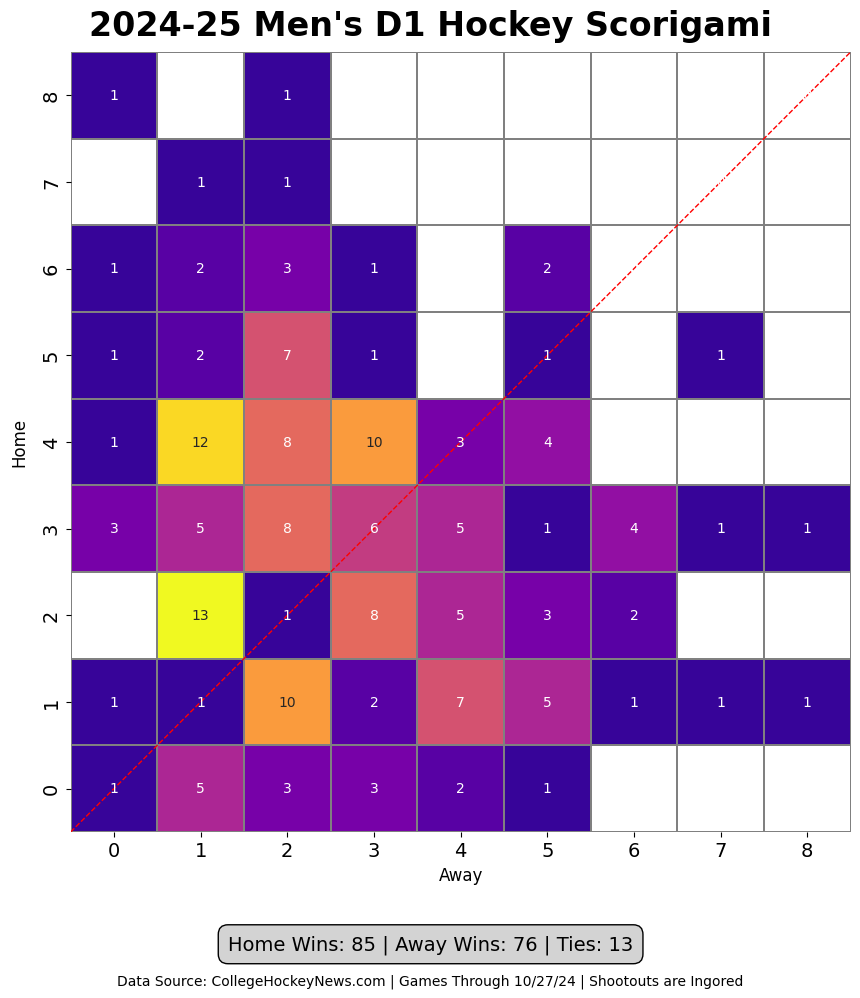

In [127]:
## Call the function
plot_scorigami(score_combinations, home_wins, away_wins, ties, today_ns)

## Woman's Hockey Results Scrape

###### Hide Code

In [128]:
from bs4 import BeautifulSoup
import requests
import re

# url of CHN woman's results page - Only includes results from Oct 1 on - need to manually get and add September games
urls = ['https://www.collegehockeynews.com/women/schedule.php?date=20240920', 
        'https://www.collegehockeynews.com/women/schedule.php?date=20240927', 
        'https://www.collegehockeynews.com/women/schedule.php?season=20242025']

# url = 'https://www.collegehockeynews.com/women/schedule.php?season=20242025'

def get_game_data(url):
    # Get the page with requests
    response = requests.get(url)

    # Create a BeautifulSoup object
    soup = BeautifulSoup(response.text, 'html.parser')

    # select the table or tables
    tables = soup.find_all('table')

    # Initialize variables
    current_date = None
    current_conference = None
    game_notes = None

    # Initialize an empty list to hold the data
    data = []

    # Parse the table with BeautifulSoup

    rows = soup.find_all('tr')

    # Loop through each row to find relevant information
    for row in rows:
        # Check for date row
        if row.get('class') == ['stats-section']:
            current_date = row.find('td').text.strip()
        # Check for conference row
        elif row.get('class') == ['sked-header']:
            current_conference = row.find('td').text.strip()
        # Check for game notes
        elif len(row.find_all('td')) == 2:
            game_notes = row.find_all('td')[1].text.strip()
        # Process rows with game data
        elif row.get('valign') == 'top':
            cells = row.find_all('td')
            if len(cells) >= 9:
                home_team = cells[0].text.strip()
                home_team_link = cells[0].find('a')['href'] if cells[0].find('a') else None
                home_score = cells[1].text.strip()
                away_team = cells[3].text.strip()
                away_team_link = cells[3].find('a')['href'] if cells[3].find('a') else None
                away_score = cells[4].text.strip()
                ot = cells[5].text.strip()
                box_link = cells[7].find('a')['href'] if cells[7].find('a') else None
                metrics_link = cells[8].find('a')['href'] if cells[8].find('a') else None
                # Capture Game Notes
                game_notes_cell = cells[-1].find('small')
                game_notes = game_notes_cell.text.strip() if game_notes_cell else None

                # Append data to the list
                data.append([current_date, current_conference, game_notes, home_team, home_team_link, home_score, away_team, away_team_link, away_score, ot, box_link, metrics_link])
                game_notes = None  # Reset game notes for the next row

    return data

# Initialize an empty list to hold all the data
data = []

# loop through all the urls
for url in urls:
    data += get_game_data(url)
                


# Create a DataFrame
columns = ['Date', 'Conference', 'Game_Notes', 'Away_Team', 'Away_Team_Link', 'Away_Score', 'Home_Team', 'Home_Team_Link', 'Home_Score',  'OT', 'Box_Link', 'Metrics_Link']
df = pd.DataFrame(data, columns=columns)

# # Clean Team names for ease of use (remove any dashes, ' or periods)
df['Away_Team'] = df['Away_Team'].str.replace("'", "").str.replace(".", "").str.replace("-", " ")
df['Home_Team'] = df['Home_Team'].str.replace("'", "").str.replace(".", "").str.replace("-", " ")

print('Original Length:', len(df))

# Drop any duplicate rows
df.drop_duplicates(inplace=True)

print('After Dropping Duplicates:', len(df))

# Drop Exhibition games
df = df[~df['Conference'].str.contains('Exhibition')]

print('After Dropping Exhibition Games:', len(df))
df.head(5)
# Rename to w_results_df
# w_results_df = df

Original Length: 780
After Dropping Duplicates: 750
After Dropping Exhibition Games: 739


,Date,Conference,Game_Notes,Away_Team,Away_Team_Link,Away_Score,Home_Team,Home_Team_Link,Home_Score,OT,Box_Link,Metrics_Link
6,"Saturday, September 21, 2024",WCHA,,Minnesota Duluth,/women/team/Minnesota-Duluth/36,2,Ohio State,/women/team/Ohio-State/44,1,,/box/final/20240921/mnd/osu/w,None
7,"Saturday, September 21, 2024",Non-Conference,,St Cloud State,/women/team/St-Cloud-State/52,4,Lindenwood,/women/team/Lindenwood/433,0,,/box/final/20240921/stc/lin/w,None
8,"Sunday, September 22, 2024",Non-Conference,,St Cloud State,/women/team/St-Cloud-State/52,6,Lindenwood,/women/team/Lindenwood/433,2,,/box/final/20240922/stc/lin/w,None
12,"Sunday, September 22, 2024",WCHA,,Minnesota Duluth,/women/team/Minnesota-Duluth/36,4,Ohio State,/women/team/Ohio-State/44,3,,/box/final/20240922/mnd/osu/w,None
13,"Thursday, September 26, 2024",Non-Conference,,Northeastern,/women/team/Northeastern/41,3,Penn State,/women/team/Penn-State/60,1,,/box/final/20240926/noe/psu/w,None


In [129]:
# Filter out exhibition games 
filtered_data = df.copy()

# Ensure df.copy() is correctly used
# filtered_data = data[data['Conference'] != 'Exhibition']

# Check if the 'Home_Score' and 'Away_Score' columns exist and have numeric data
if 'Home_Score' not in filtered_data.columns or 'Away_Score' not in filtered_data.columns:
    raise ValueError("Home_Score or Away_Score columns are missing.")

# Check for missing or non-numeric values in the score columns
filtered_data['Home_Score'] = pd.to_numeric(filtered_data['Home_Score'], errors='coerce')
filtered_data['Away_Score'] = pd.to_numeric(filtered_data['Away_Score'], errors='coerce')

# Drop rows with missing values in scores
filtered_data.dropna(subset=['Home_Score', 'Away_Score'], inplace=True)

# Ensure all score values are integers
filtered_data['Home_Score'] = filtered_data['Home_Score'].astype(int)
filtered_data['Away_Score'] = filtered_data['Away_Score'].astype(int)

# Determine the maximum scores for both home and away teams
max_home_score = filtered_data['Home_Score'].max()
max_away_score = filtered_data['Away_Score'].max()
max_home_score, max_away_score = int(max_home_score), int(max_away_score)

# Calculate total home wins, away wins, and ties
home_wins = len(filtered_data[filtered_data['Home_Score'] > filtered_data['Away_Score']])
away_wins = len(filtered_data[filtered_data['Away_Score'] > filtered_data['Home_Score']])
ties = len(filtered_data[filtered_data['Home_Score'] == filtered_data['Away_Score']])

# Create a pivot table to aggregate game counts for each score combination
score_combinations = pd.pivot_table(filtered_data, index='Home_Score', columns='Away_Score', values='Date', aggfunc='count', fill_value=0)

# Fill in any missing score combinations with zeros
all_scores = np.arange(0, max(max_home_score, max_away_score) + 1)
score_combinations = score_combinations.reindex(index=all_scores, columns=all_scores, fill_value=0)

# Ensure pivot table values are integers
score_combinations = score_combinations.astype(int)
# score_combinations


In [130]:

date = today
# Define figure size to maintain a 4:5 ratio while ensuring the heatmap grid stays 1:1
### OLD # figure_ratio = (8, 10)  # Adjusted for mobile-friendly aspect ratio

# Function to create a scorigami plot for Women's Results
def create_scorigami_plot(data, date=today):
    # Customizing the colormap with transparency for zeros
    cmap = sns.color_palette(palette=set_pallette, as_cmap=True)
    cmap_with_transparency = ListedColormap([(0,0,0,0)] + [cmap(i) for i in range(1, cmap.N)])

    # Create a figure with constrained layout to ensure the grid aspect stays 1:1
    fig = plt.figure(figsize=figure_ratio)

    # Create the title
    plt.suptitle("2024-25 Women's D1 Hockey Scorigami", fontsize=24, fontweight='bold', color='black', y=0.98)
    # Create Subtitle for the week #
    plt.title(f'Week 1', fontsize=18, fontweight='bold', color='black', y=0.95)

    # Create a new axis for the heatmap with the grid maintaining a 1:1 aspect ratio
    # ax1 = fig.add_axes([0.05, 0.2, 0.98, 0.6])  # Adjusted placement to reduce whitespace
    # Placement for mobile-friendly aspect ratio
    ax1 = fig.add_axes([0.05, 0.05, 0.975, 0.995])  # Adjusted placement to reduce whitespace
    sns.heatmap(score_combinations, annot=True, mask=None, cmap=cmap_with_transparency, fmt="d", linewidths=.25, 
                linecolor='gray', cbar=False, square=True, ax=ax1)

    # Invert y-axis to ensure 0 is at the bottom
    ax1.invert_yaxis()

    # Axis labels
    ax1.set_xlabel('Away', fontsize=12) #, labelpad=10)
    # Rotate the y-axis label 90 degrees for better readability
    ax1.set_ylabel('Home', fontsize=12, rotation=90, labelpad=10)



    # ax1.set_ylabel('Home', fontsize=12) # labelpad=10)

    # Customize tick labels
    ax1.set_xticks(np.arange(0.5, len(all_scores)+0.5, 1))
    ax1.set_xticklabels(all_scores, fontsize=14)
    ax1.set_yticks(np.arange(0.5, len(all_scores)+0.5, 1))
    ax1.set_yticklabels(all_scores, fontsize=14)

    # Add a diagonal line for home vs away parity
    ax1.plot([0, len(all_scores)], [0, len(all_scores)], color='red', linestyle='--', linewidth=1)

    # # Create a new axis for the color bar below the heatmap
    # ax2 = fig.add_axes([0.15, 0.1, 0.7, 0.02])  # Adjust placement for color bar
    # cbar = plt.colorbar(ax1.collections[0], cax=ax2, orientation='horizontal')
    # Restored the color bar label for clarity
    # cbar.set_label('Game Frequency', fontsize=14) # Uncomment to add a label - DUMB

    # Add the leaderboard box below the color bar
    props = dict(boxstyle='round,pad=0.5', facecolor='lightgray', edgecolor='black')
    leaderboard_text = f'Home Wins: {home_wins} | Away Wins: {away_wins} | Ties: {ties}'
    plt.text(0.5, 0.04, leaderboard_text, fontsize=14, color='black', ha='center', bbox=props, transform=fig.transFigure)

    # Add data source and date at the very bottom with better padding
    plt.figtext(0.5, 0.005, f'Data Source: CollegeHockeyNews.com | Games Through {date}', fontsize=10, color='black', ha='center')

    # Adjust the layout to reduce overall whitespace
    plt.subplots_adjust(top=.90, bottom=0.5, left=0.1, right=0.9, hspace=0.2)

    # Save the plot as an image in the scor_o_path directory
    plt.savefig(os.path.join(scor_o_path, f"womens_scrigami_{today_ns}.png"), dpi=300, bbox_inches='tight')
    

    # # Display the plot
    plt.show()

#### Output

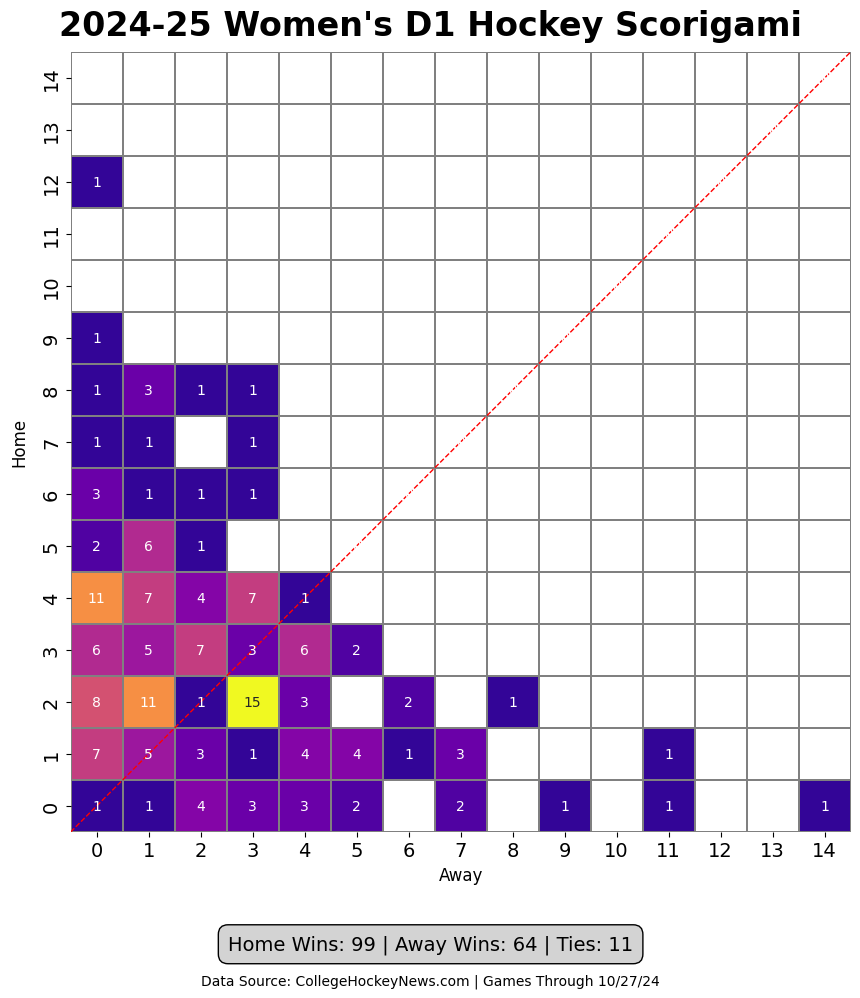

In [131]:
## Call the function to create the plot
create_scorigami_plot(filtered_data, date)

## Basic Code - taken from previous year notebook

In [132]:
# # Create a mask where the data is 0
# mask = score_combinations == 0

# # Customizing the colormap: add a transparent color for 0 values
# # We take the original colormap, add a transparent color for 0 and keep the rest as is.
# # This example uses "YlGnBu", but you can change it to your preferred colormap.
# cmap = sns.color_palette("YlGnBu", as_cmap=True)
# cmap_with_transparency = ListedColormap([(0,0,0,0)] + [cmap(i) for i in range(1, cmap.N)])

# # Plotting the heatmap with modifications
# plt.figure(figsize=(12, 10))
# sns.heatmap(score_combinations, annot=True, mask=mask, cmap=cmap_with_transparency, fmt="d", linewidths=.5,
#             cbar_kws={'ticks': range(1, max(max_home_score, max_away_score) + 1)})  # Adjust colorbar ticks if necessary
# plt.title('College Hockey Game Scoreboard Bingo', fontsize=16)
# # Add a note of the start and end dates - under the title in upper right of the plot

# plt.xlabel('Away Team', fontsize=14) # Set to Blank to remove the label
# plt.ylabel('Home Team', fontsize=14) # Set to Blank to remove the label
# plt.xticks(np.arange(0.5, len(all_scores)+0.5, 1), all_scores)
# plt.yticks(np.arange(0.5, len(all_scores)+0.5, 1), all_scores, rotation=0)

# # Custom function to make text annotations transparent for 0 values
# for text in plt.gca().texts:
#     if text.get_text() == '0':
#         text.set_alpha(0)

# # Invert y-axis so 0 is at the bottom
# plt.gca().invert_yaxis()




# ## Set Hard Coded axis ranges
# # plt.xlim(0, 15)
# # plt.ylim(0, 15)




# # plt.show()


<!-- ## Version 1.1 -->

<!-- ## Men's Working Version -->

In [133]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# from matplotlib.colors import ListedColormap

# date = today
# # Define figure size to maintain a 4:5 ratio while ensuring the heatmap grid stays 1:1
# figure_ratio = (8, 10)  # Adjusted for mobile-friendly aspect ratio

# # Customizing the colormap with transparency for zeros
# cmap = sns.color_palette(palette='coolwarm', as_cmap=True)
# cmap_with_transparency = ListedColormap([(0,0,0,0)] + [cmap(i) for i in range(1, cmap.N)])

# # Create a figure with constrained layout to ensure the grid aspect stays 1:1
# fig = plt.figure(figsize=figure_ratio)

# # Create the title
# plt.suptitle("2024-25 Men's D1 Hockey Scorigami", fontsize=24, fontweight='bold', color='black', y=0.98)
# # Create Subtitle for the week #
# plt.title(f'Week 1', fontsize=18, fontweight='bold', color='black', y=0.95)

# # Create a new axis for the heatmap with the grid maintaining a 1:1 aspect ratio
# # ax1 = fig.add_axes([0.05, 0.2, 0.98, 0.6])  # Adjusted placement to reduce whitespace
# # Placement for mobile-friendly aspect ratio
# ax1 = fig.add_axes([0.05, 0.05, 0.975, 0.995])  # Adjusted placement to reduce whitespace
# sns.heatmap(score_combinations, annot=True, mask=None, cmap=cmap_with_transparency, fmt="d", linewidths=.25, 
#             linecolor='gray', cbar=False, square=True, ax=ax1)

# # Invert y-axis to ensure 0 is at the bottom
# ax1.invert_yaxis()

# # Axis labels
# ax1.set_xlabel('Away', fontsize=12) #, labelpad=10)
# # Rotate the y-axis label 90 degrees for better readability
# ax1.set_ylabel('Home', fontsize=12, rotation=90, labelpad=10)



# # ax1.set_ylabel('Home', fontsize=12) # labelpad=10)

# # Customize tick labels
# ax1.set_xticks(np.arange(0.5, len(all_scores)+0.5, 1))
# ax1.set_xticklabels(all_scores, fontsize=14)
# ax1.set_yticks(np.arange(0.5, len(all_scores)+0.5, 1))
# ax1.set_yticklabels(all_scores, fontsize=14)

# # Add a diagonal line for home vs away parity
# ax1.plot([0, len(all_scores)], [0, len(all_scores)], color='red', linestyle='--', linewidth=1)

# # # Create a new axis for the color bar below the heatmap
# # ax2 = fig.add_axes([0.15, 0.1, 0.7, 0.02])  # Adjust placement for color bar
# # cbar = plt.colorbar(ax1.collections[0], cax=ax2, orientation='horizontal')
# # Restored the color bar label for clarity
# # cbar.set_label('Game Frequency', fontsize=14) # Uncomment to add a label - DUMB

# # Add the leaderboard box below the color bar
# props = dict(boxstyle='round,pad=0.5', facecolor='lightgray', edgecolor='black')
# leaderboard_text = f'Home Wins: {home_wins} | Away Wins: {away_wins} | Ties: {ties}'
# plt.text(0.5, 0.04, leaderboard_text, fontsize=14, color='black', ha='center', bbox=props, transform=fig.transFigure)

# # Add data source and date at the very bottom with better padding
# plt.figtext(0.5, 0.005, f'Data Source: CollegeHockeyNews.com | Games Through {date}', fontsize=10, color='black', ha='center')

# # Adjust the layout to reduce overall whitespace
# plt.subplots_adjust(top=.90, bottom=0.5, left=0.1, right=0.9, hspace=0.2)

# # Display the plot
# plt.show()
